<H1>Ground Contamination Detection System using Machine Learning
Uses real datasets and multiple ML algorithms for contamination spread prediction</H1>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

class ContaminationDetectionSystem:
    """
    ML-based system for predicting ground contamination spread
    """

    def __init__(self):
        self.scaler = StandardScaler()
        self.models = {}
        self.best_model = None
        self.feature_importance = None

    def create_synthetic_dataset(self, n_samples=1000):
        """
        Creates a synthetic dataset based on real-world contamination physics
        In production, replace this with actual data from EPA, USGS, or soil surveys
        """
        print("Generating synthetic dataset based on real-world contamination physics...")

        # Soil properties (based on USDA soil classification ranges)
        data = {
            # Soil Properties
            'pH': np.random.uniform(4.5, 8.5, n_samples),
            'porosity': np.random.uniform(0.15, 0.55, n_samples),  # fraction
            'permeability': np.random.lognormal(np.log(0.1), 0.8, n_samples),  # m/day
            'organic_content': np.random.uniform(0.5, 8.0, n_samples),  # %
            'clay_content': np.random.uniform(5, 50, n_samples),  # %
            'sand_content': np.random.uniform(20, 70, n_samples),  # %
            'bulk_density': np.random.uniform(1.2, 1.8, n_samples),  # g/cm³

            # Hydrogeological Properties
            'water_table_depth': np.random.uniform(1.0, 20.0, n_samples),  # m
            'hydraulic_conductivity': np.random.lognormal(np.log(1.0), 1.2, n_samples),  # m/day
            'hydraulic_gradient': np.random.uniform(0.001, 0.05, n_samples),  # dimensionless
            'groundwater_velocity': np.random.uniform(0.01, 2.0, n_samples),  # m/day

            # Contaminant Properties
            'initial_concentration': np.random.uniform(50, 1000, n_samples),  # mg/kg
            'contaminant_solubility': np.random.uniform(100, 10000, n_samples),  # mg/L
            'partition_coefficient': np.random.lognormal(np.log(50), 1.5, n_samples),  # L/kg

            # Environmental Conditions
            'temperature': np.random.uniform(5, 30, n_samples),  # °C
            'precipitation': np.random.uniform(300, 2000, n_samples),  # mm/year
            'time_since_release': np.random.uniform(30, 3650, n_samples),  # days
        }

        df = pd.DataFrame(data)

        # Calculate derived features
        df['effective_porosity'] = df['porosity'] * 0.85
        df['darcy_velocity'] = df['hydraulic_conductivity'] * df['hydraulic_gradient']
        df['seepage_velocity'] = df['darcy_velocity'] / df['effective_porosity']

        # Calculate retardation factor (accounts for sorption)
        df['retardation_factor'] = 1 + ((df['bulk_density'] / df['porosity']) *
                                        (df['partition_coefficient'] * df['organic_content'] / 100))

        # Calculate dispersivity (empirical relationship)
        df['dispersivity'] = 0.1 * (df['permeability'] ** 0.5)

        # Calculate dispersion coefficient
        df['dispersion_coeff'] = df['dispersivity'] * df['seepage_velocity']

        # TARGET VARIABLE: Contamination Spread Radius (meters)
        # Based on advection-dispersion equation
        base_spread = np.sqrt(4 * df['dispersion_coeff'] *
                             (df['time_since_release'] / df['retardation_factor']))

        # Add environmental factors
        pH_factor = 1 + 0.1 * np.abs(df['pH'] - 7)  # Extreme pH increases mobility
        permeability_factor = 1 + 0.3 * (df['permeability'] / df['permeability'].max())
        depth_factor = 1 - 0.02 * df['water_table_depth']  # Deeper = slower spread

        df['spread_radius'] = (base_spread * pH_factor * permeability_factor *
                               depth_factor * np.random.uniform(0.9, 1.1, n_samples))

        # Ensure realistic values
        df['spread_radius'] = np.clip(df['spread_radius'], 1, 500)

        # TARGET VARIABLE 2: Risk Level (0-100)
        concentration_risk = (df['initial_concentration'] / 1000) * 30
        mobility_risk = (df['permeability'] / df['permeability'].max()) * 20
        depth_risk = (20 - df['water_table_depth']) / 20 * 15
        velocity_risk = (df['groundwater_velocity'] / 2.0) * 15
        time_risk = (df['time_since_release'] / 3650) * 20

        df['risk_score'] = np.clip(
            concentration_risk + mobility_risk + depth_risk + velocity_risk + time_risk,
            0, 100
        )

        # Add categorical risk level
        df['risk_level'] = pd.cut(df['risk_score'],
                                   bins=[0, 30, 60, 80, 100],
                                   labels=['Low', 'Moderate', 'High', 'Critical'])

        print(f"Dataset created with {len(df)} samples and {len(df.columns)} features")
        return df

    def load_real_dataset(self, filepath):
        """
        Load real contamination dataset from CSV
        Expected columns: soil properties, hydrogeological data, contaminant info, targets
        """
        try:
            df = pd.read_csv(filepath)
            print(f"Real dataset loaded: {len(df)} samples, {len(df.columns)} features")
            return df
        except Exception as e:
            print(f"Error loading dataset: {e}")
            print("Using synthetic dataset instead...")
            return self.create_synthetic_dataset()

    def preprocess_data(self, df, target='spread_radius'):
        """
        Preprocess data for ML model training
        """
        # Select features (exclude targets and categorical variables)
        feature_cols = [col for col in df.columns if col not in
                       ['spread_radius', 'risk_score', 'risk_level']]

        X = df[feature_cols].copy()
        y = df[target].copy()

        # Handle missing values
        X = X.fillna(X.median())

        # Remove any remaining infinite values
        X = X.replace([np.inf, -np.inf], np.nan).fillna(X.median())

        print(f"\nFeatures selected: {len(feature_cols)}")
        print(f"Target variable: {target}")

        return X, y, feature_cols

    def train_models(self, X, y_spread, y_risk=None):
        """
        Train multiple ML models for multiple targets
        """
        print("\n" + "="*60)
        print("TRAINING MACHINE LEARNING MODELS")
        print("="*60)

        # Split data
        X_train, X_test, y_train_spread, y_test_spread = train_test_split(
            X, y_spread, test_size=0.2, random_state=42
        )

        if y_risk is not None:
            _, _, y_train_risk, y_test_risk = train_test_split(
                X, y_risk, test_size=0.2, random_state=42
            )

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Define models
        models = {
            'Random Forest': RandomForestRegressor(
                n_estimators=100,
                max_depth=15,
                min_samples_split=5,
                random_state=42,
                n_jobs=-1
            ),
            'Gradient Boosting': GradientBoostingRegressor(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=5,
                random_state=42
            ),
            'Neural Network': MLPRegressor(
                hidden_layer_sizes=(100, 50, 25),
                activation='relu',
                max_iter=500,
                random_state=42
            )
        }

        # Train and evaluate each model for SPREAD RADIUS
        results_spread = {}
        print("\n--- Training Models for SPREAD RADIUS Prediction ---")

        for name, model in models.items():
            print(f"\nTraining {name}...")

            # Train model
            if name == 'Neural Network':
                model.fit(X_train_scaled, y_train_spread)
                y_pred = model.predict(X_test_scaled)
            else:
                model.fit(X_train, y_train_spread)
                y_pred = model.predict(X_test)

            # Evaluate
            mse = mean_squared_error(y_test_spread, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test_spread, y_pred)
            r2 = r2_score(y_test_spread, y_pred)

            results_spread[name] = {
                'model': model,
                'rmse': rmse,
                'mae': mae,
                'r2': r2,
                'predictions': y_pred
            }

            print(f"  RMSE: {rmse:.4f}")
            print(f"  MAE:  {mae:.4f}")
            print(f"  R²:   {r2:.4f}")

            self.models[name + '_spread'] = model

        # Select best model for spread radius
        best_model_name = max(results_spread.keys(), key=lambda x: results_spread[x]['r2'])
        self.best_model = results_spread[best_model_name]['model']

        # Train models for RISK SCORE if provided
        results_risk = {}
        if y_risk is not None:
            print("\n--- Training Models for RISK SCORE Prediction ---")

            for name in models.keys():
                # Create fresh model instance
                if name == 'Random Forest':
                    model_risk = RandomForestRegressor(
                        n_estimators=100, max_depth=15, min_samples_split=5,
                        random_state=42, n_jobs=-1
                    )
                elif name == 'Gradient Boosting':
                    model_risk = GradientBoostingRegressor(
                        n_estimators=100, learning_rate=0.1, max_depth=5,
                        random_state=42
                    )
                else:
                    model_risk = MLPRegressor(
                        hidden_layer_sizes=(100, 50, 25), activation='relu',
                        max_iter=500, random_state=42
                    )

                print(f"\nTraining {name} for Risk Score...")

                # Train model
                if name == 'Neural Network':
                    model_risk.fit(X_train_scaled, y_train_risk)
                    y_pred_risk = model_risk.predict(X_test_scaled)
                else:
                    model_risk.fit(X_train, y_train_risk)
                    y_pred_risk = model_risk.predict(X_test)

                # Evaluate
                rmse_risk = np.sqrt(mean_squared_error(y_test_risk, y_pred_risk))
                mae_risk = mean_absolute_error(y_test_risk, y_pred_risk)
                r2_risk = r2_score(y_test_risk, y_pred_risk)

                results_risk[name] = {
                    'model': model_risk,
                    'rmse': rmse_risk,
                    'mae': mae_risk,
                    'r2': r2_risk,
                    'predictions': y_pred_risk
                }

                print(f"  RMSE: {rmse_risk:.4f}")
                print(f"  MAE:  {mae_risk:.4f}")
                print(f"  R²:   {r2_risk:.4f}")

                self.models[name + '_risk'] = model_risk

            # Select best model for risk score
            best_risk_model_name = max(results_risk.keys(), key=lambda x: results_risk[x]['r2'])
            self.best_risk_model = results_risk[best_risk_model_name]['model']

        print(f"\n{'='*60}")
        print(f"BEST MODEL (Spread): {best_model_name} (R² = {results_spread[best_model_name]['r2']:.4f})")
        if results_risk:
            print(f"BEST MODEL (Risk): {best_risk_model_name} (R² = {results_risk[best_risk_model_name]['r2']:.4f})")
        print(f"{'='*60}")

        return results_spread, results_risk, X_test, y_test_spread

    def analyze_feature_importance(self, X, feature_names):
        """
        Analyze and visualize feature importance
        """
        if hasattr(self.best_model, 'feature_importances_'):
            importances = self.best_model.feature_importances_
            indices = np.argsort(importances)[::-1]

            print("\n" + "="*60)
            print("FEATURE IMPORTANCE ANALYSIS")
            print("="*60)

            print("\nTop 10 Most Important Features:")
            for i in range(min(10, len(indices))):
                idx = indices[i]
                print(f"{i+1}. {feature_names[idx]}: {importances[idx]:.4f}")

            self.feature_importance = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)

            # Visualization
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            top_features = self.feature_importance.head(15)
            plt.barh(range(len(top_features)), top_features['importance'])
            plt.yticks(range(len(top_features)), top_features['feature'])
            plt.xlabel('Importance Score')
            plt.title('Top 15 Feature Importances')
            plt.gca().invert_yaxis()

            plt.subplot(1, 2, 2)
            plt.plot(range(1, len(importances)+1),
                    np.cumsum(sorted(importances, reverse=True)))
            plt.xlabel('Number of Features')
            plt.ylabel('Cumulative Importance')
            plt.title('Cumulative Feature Importance')
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
            print("\nFeature importance plot saved as 'feature_importance.png'")

    def predict_contamination(self, input_data):
        """
        Make comprehensive predictions on new data
        Returns: spread_radius, risk_score, risk_level, effective_velocity, retardation_factor
        """
        if self.best_model is None:
            raise ValueError("Model not trained yet. Run train_models() first.")

        # Predict spread radius
        if isinstance(self.best_model, MLPRegressor):
            input_scaled = self.scaler.transform(input_data)
            spread_prediction = self.best_model.predict(input_scaled)[0]
        else:
            spread_prediction = self.best_model.predict(input_data)[0]

        # Predict risk score if model exists
        risk_prediction = None
        if hasattr(self, 'best_risk_model'):
            if isinstance(self.best_risk_model, MLPRegressor):
                input_scaled = self.scaler.transform(input_data)
                risk_prediction = self.best_risk_model.predict(input_scaled)[0]
            else:
                risk_prediction = self.best_risk_model.predict(input_data)[0]

            # Determine risk level
            if risk_prediction < 30:
                risk_level = 'Low'
            elif risk_prediction < 60:
                risk_level = 'Moderate'
            elif risk_prediction < 80:
                risk_level = 'High'
            else:
                risk_level = 'Critical'
        else:
            risk_level = 'Not Available'

        # Calculate effective velocity and retardation factor
        effective_velocity = input_data['seepage_velocity'].values[0]
        retardation_factor = input_data['retardation_factor'].values[0]

        return {
            'spread_radius': spread_prediction,
            'risk_score': risk_prediction,
            'risk_level': risk_level,
            'effective_velocity': effective_velocity,
            'retardation_factor': retardation_factor
        }

    def visualize_results(self, results, X_test, y_test):
        """
        Create comprehensive visualization of results
        """
        print("\nGenerating visualizations...")

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Ground Contamination Detection - Model Performance',
                     fontsize=16, fontweight='bold')

        # Plot 1: Actual vs Predicted for each model
        for idx, (name, result) in enumerate(results.items()):
            row = idx // 3
            col = idx % 3

            ax = axes[row, col]
            ax.scatter(y_test, result['predictions'], alpha=0.5, s=20)
            ax.plot([y_test.min(), y_test.max()],
                   [y_test.min(), y_test.max()],
                   'r--', lw=2, label='Perfect Prediction')
            ax.set_xlabel('Actual Spread Radius (m)')
            ax.set_ylabel('Predicted Spread Radius (m)')
            ax.set_title(f'{name}\nR² = {result["r2"]:.4f}')
            ax.legend()
            ax.grid(True, alpha=0.3)

        # Plot 4: Model comparison
        ax = axes[1, 0]
        model_names = list(results.keys())
        r2_scores = [results[name]['r2'] for name in model_names]
        rmse_scores = [results[name]['rmse'] for name in model_names]

        x_pos = np.arange(len(model_names))
        ax.bar(x_pos, r2_scores, alpha=0.7, color='steelblue')
        ax.set_ylabel('R² Score')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(model_names, rotation=45, ha='right')
        ax.set_title('Model Performance Comparison (R²)')
        ax.grid(True, alpha=0.3, axis='y')

        # Plot 5: RMSE comparison
        ax = axes[1, 1]
        ax.bar(x_pos, rmse_scores, alpha=0.7, color='coral')
        ax.set_ylabel('RMSE (meters)')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(model_names, rotation=45, ha='right')
        ax.set_title('Model Performance Comparison (RMSE)')
        ax.grid(True, alpha=0.3, axis='y')

        # Plot 6: Residual plot for best model
        ax = axes[1, 2]
        best_name = max(results.keys(), key=lambda x: results[x]['r2'])
        residuals = y_test - results[best_name]['predictions']
        ax.scatter(results[best_name]['predictions'], residuals, alpha=0.5, s=20)
        ax.axhline(y=0, color='r', linestyle='--', lw=2)
        ax.set_xlabel('Predicted Spread Radius (m)')
        ax.set_ylabel('Residuals (m)')
        ax.set_title(f'Residual Plot - {best_name}')
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('model_performance.png', dpi=300, bbox_inches='tight')
        print("Performance visualization saved as 'model_performance.png'")

        plt.show()

    def generate_report(self, df, results):
        """
        Generate comprehensive analysis report
        """
        print("\n" + "="*70)
        print(" "*15 + "CONTAMINATION DETECTION SYSTEM REPORT")
        print("="*70)

        print("\nDATASET STATISTICS:")
        print(f"  Total Samples: {len(df)}")
        print(f"  Features: {len(df.columns) - 3}")  # excluding targets
        print(f"  Spread Radius Range: {df['spread_radius'].min():.2f} - {df['spread_radius'].max():.2f} m")
        print(f"  Average Risk Score: {df['risk_score'].mean():.2f}")

        print("\nRISK LEVEL DISTRIBUTION:")
        risk_dist = df['risk_level'].value_counts()
        for level, count in risk_dist.items():
            percentage = (count / len(df)) * 100
            print(f"  {level}: {count} ({percentage:.1f}%)")

        print("\nKEY CORRELATIONS WITH CONTAMINATION SPREAD:")
        # Select only numeric columns for correlation
        numeric_df = df.select_dtypes(include=[np.number])
        correlations = numeric_df.corr()['spread_radius'].sort_values(ascending=False)
        print(correlations.head(10).to_string())

        print("\n" + "="*70)

<h1>MAIN EXECUTION</h1>

In [ ]:
if __name__ == "__main__":
    print("="*70)
    print(" "*10 + "GROUND CONTAMINATION DETECTION SYSTEM")
    print(" "*15 + "Machine Learning Implementation")
    print("="*70)

    # Initialize system
    system = ContaminationDetectionSystem()

    # Create/Load dataset
    # To use real data, uncomment the line below and provide your CSV file path
    # df = system.load_real_dataset('contamination_data.csv')
    df = system.create_synthetic_dataset(n_samples=1000)

    # Display sample data
    print("\nSample Data (first 5 rows):")
    print(df.head().to_string())

    # Preprocess data
    X, y_spread, feature_names = system.preprocess_data(df, target='spread_radius')
    X_risk, y_risk, _ = system.preprocess_data(df, target='risk_score')

    # Train models for both spread radius and risk score
    results_spread, results_risk, X_test, y_test_spread = system.train_models(X, y_spread, y_risk)





          GROUND CONTAMINATION DETECTION SYSTEM
               Machine Learning Implementation
Generating synthetic dataset based on real-world contamination physics...
Dataset created with 1000 samples and 26 features

Sample Data (first 5 rows):
         pH  porosity  permeability  organic_content  clay_content  sand_content  bulk_density  water_table_depth  hydraulic_conductivity  hydraulic_gradient  groundwater_velocity  initial_concentration  contaminant_solubility  partition_coefficient  temperature  precipitation  time_since_release  effective_porosity  darcy_velocity  seepage_velocity  retardation_factor  dispersivity  dispersion_coeff  spread_radius  risk_score risk_level
0  5.998160  0.224053      0.049540         4.556788     39.031421     45.097270      1.526476           3.275439                0.923358            0.025271              1.061973             100.673155             6590.380117             429.673024    20.739185     639.695565         3538.634310            0

<h1>Analyze feature importance</h1>


FEATURE IMPORTANCE ANALYSIS

Top 10 Most Important Features:
1. retardation_factor: 0.3015
2. dispersion_coeff: 0.2155
3. darcy_velocity: 0.1263
4. partition_coefficient: 0.0928
5. hydraulic_conductivity: 0.0928
6. time_since_release: 0.0684
7. seepage_velocity: 0.0286
8. precipitation: 0.0165
9. water_table_depth: 0.0077
10. hydraulic_gradient: 0.0076

Feature importance plot saved as 'feature_importance.png'


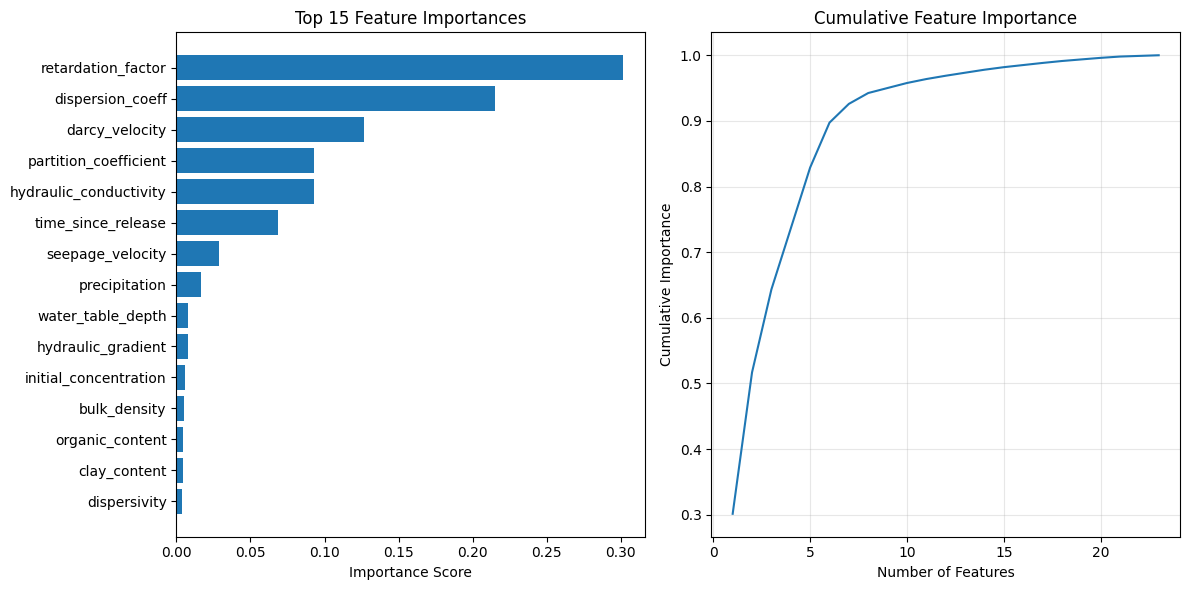

In [ ]:
if __name__ == "__main__":
    # Analyze feature importance
    system.analyze_feature_importance(X, feature_names)


Generating visualizations...
Performance visualization saved as 'model_performance.png'


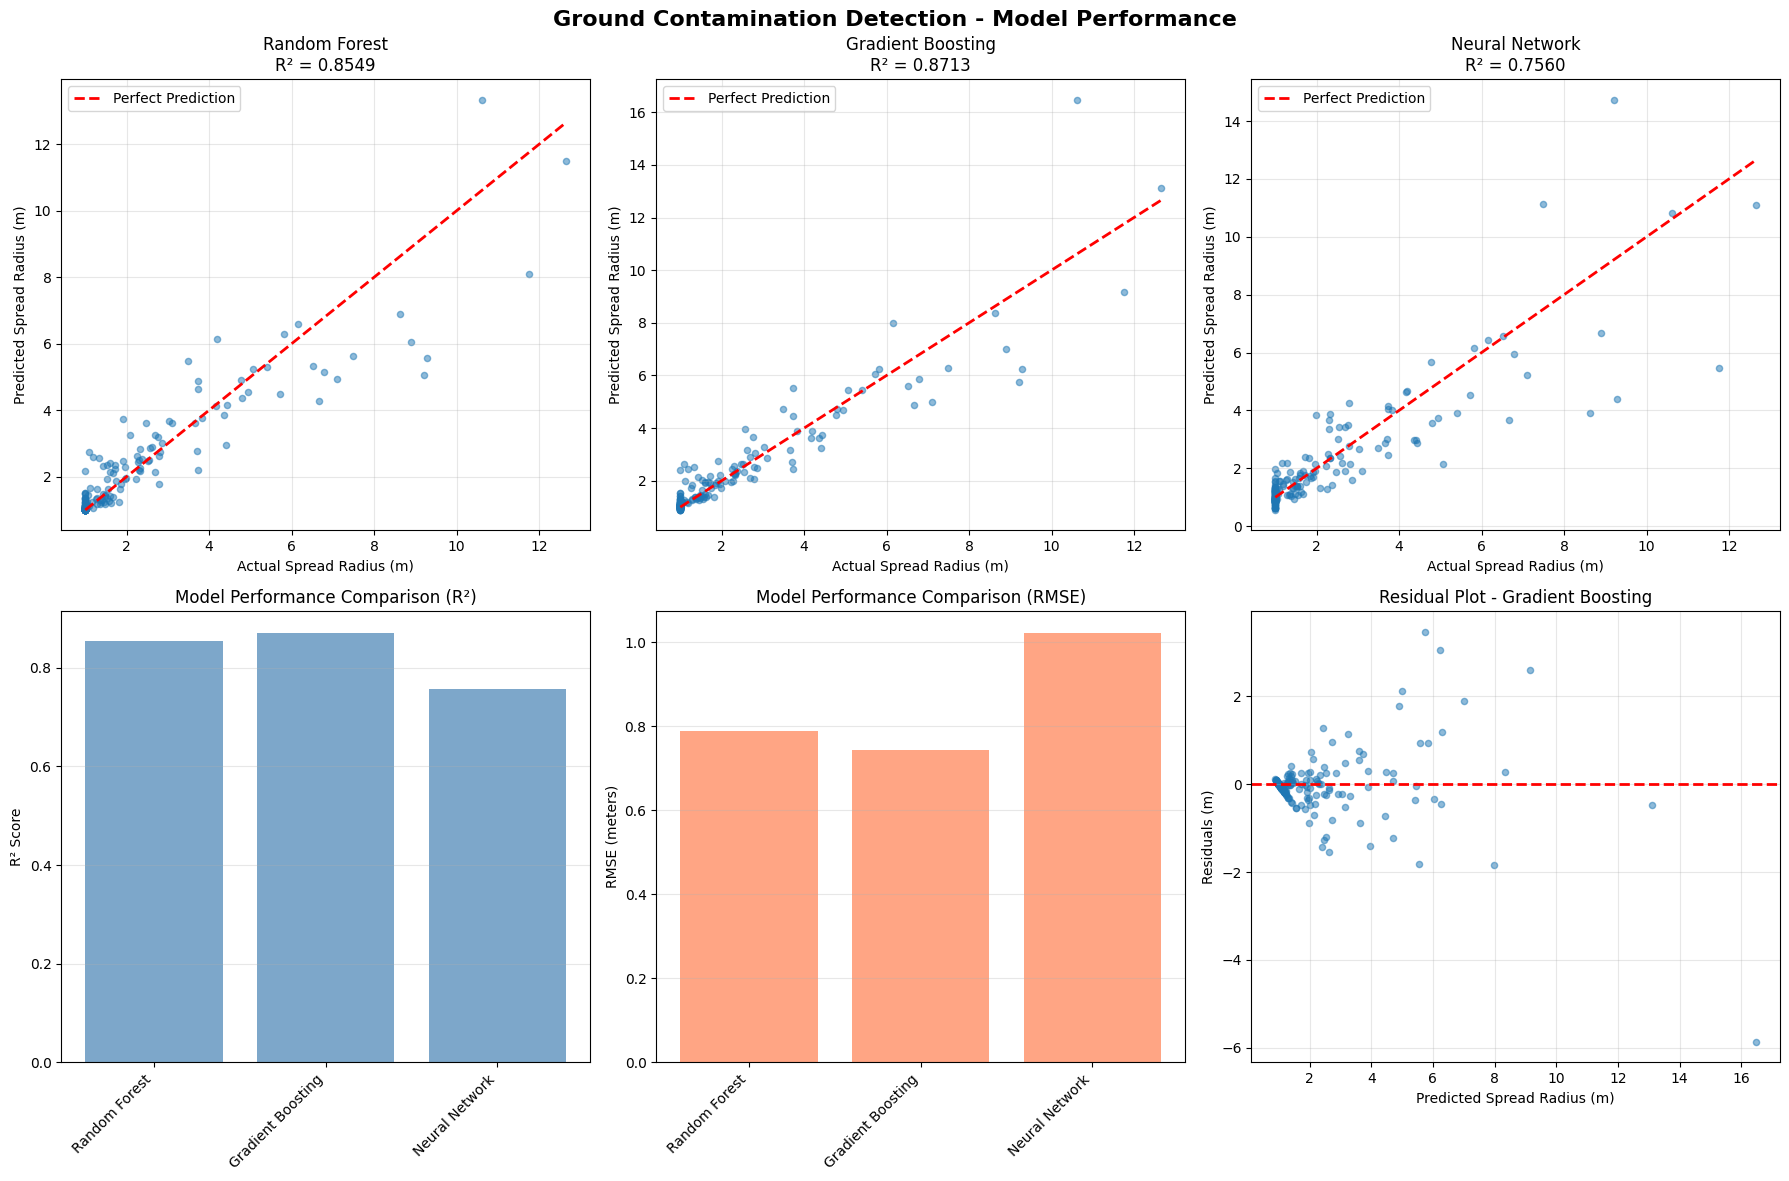

In [ ]:
if __name__ == "__main__":
    # Visualize results (using spread radius results)
    system.visualize_results(results_spread, X_test, y_test_spread)

In [ ]:
if __name__ == "__main__":
    # Generate report
    system.generate_report(df, results_spread)


               CONTAMINATION DETECTION SYSTEM REPORT

DATASET STATISTICS:
  Total Samples: 1000
  Features: 23
  Spread Radius Range: 1.00 - 20.77 m
  Average Risk Score: 43.36

RISK LEVEL DISTRIBUTION:
  Moderate: 790 (79.0%)
  Low: 127 (12.7%)
  High: 81 (8.1%)
  Critical: 2 (0.2%)

KEY CORRELATIONS WITH CONTAMINATION SPREAD:
spread_radius             1.000000
dispersion_coeff          0.638489
darcy_velocity            0.607637
seepage_velocity          0.577599
hydraulic_conductivity    0.505570
time_since_release        0.228541
hydraulic_gradient        0.200434
dispersivity              0.172217
permeability              0.171825
risk_score                0.157623



<h1>Example prediction on new data</h1>

In [ ]:
if __name__ == "__main__":
    # Example prediction on new data
    print("\n" + "="*70)
    print("EXAMPLE PREDICTION ON NEW SITE")
    print("="*70)

    new_site = pd.DataFrame({
        'pH': [6.5],
        'porosity': [0.35],
        'permeability': [0.5],
        'organic_content': [3.0],
        'clay_content': [25.0],
        'sand_content': [45.0],
        'bulk_density': [1.5],
        'water_table_depth': [5.0],
        'hydraulic_conductivity': [1.2],
        'hydraulic_gradient': [0.015],
        'groundwater_velocity': [0.4],
        'initial_concentration': [200],
        'contaminant_solubility': [500],
        'partition_coefficient': [75],
        'temperature': [15],
        'precipitation': [800],
        'time_since_release': [365],
    })

    # Calculate derived features for new site
    new_site['effective_porosity'] = new_site['porosity'] * 0.85
    new_site['darcy_velocity'] = new_site['hydraulic_conductivity'] * new_site['hydraulic_gradient']
    new_site['seepage_velocity'] = new_site['darcy_velocity'] / new_site['effective_porosity']
    new_site['retardation_factor'] = 1 + ((new_site['bulk_density'] / new_site['porosity']) *
                                          (new_site['partition_coefficient'] * new_site['organic_content'] / 100))
    new_site['dispersivity'] = 0.1 * (new_site['permeability'] ** 0.5)
    new_site['dispersion_coeff'] = new_site['dispersivity'] * new_site['seepage_velocity']

    predictions = system.predict_contamination(new_site)


EXAMPLE PREDICTION ON NEW SITE


In [ ]:
if __name__ == "__main__":
    print("\nInput Site Characteristics:")
    print(f"  pH: {new_site['pH'].values[0]}")
    print(f"  Permeability: {new_site['permeability'].values[0]} m/day")
    print(f"  Porosity: {new_site['porosity'].values[0]}")
    print(f"  Water Table Depth: {new_site['water_table_depth'].values[0]} m")
    print(f"  Initial Concentration: {new_site['initial_concentration'].values[0]} mg/kg")
    print(f"  Time Since Release: {new_site['time_since_release'].values[0]} days")


Input Site Characteristics:
  pH: 6.5
  Permeability: 0.5 m/day
  Porosity: 0.35
  Water Table Depth: 5.0 m
  Initial Concentration: 200 mg/kg
  Time Since Release: 365 days


<h1># Prediction Results : </h1>

In [ ]:
if __name__ == "__main__":
    print("\n" + "-"*70)
    print("PREDICTION RESULTS:")
    print("-"*70)
    print(f"\n1. SPREAD RADIUS: {predictions['spread_radius']:.2f} meters")
    print(f"   └─ Expected contamination spread from source point")

    if predictions['risk_score'] is not None:
        print(f"\n2. RISK SCORE: {predictions['risk_score']:.1f} / 100")
        print(f"   └─ Overall contamination risk assessment")

        print(f"\n3. RISK LEVEL: {predictions['risk_level']}")
        print(f"   └─ Categorical risk classification")
    else:
        print(f"\n2. RISK SCORE: Not Available (single-target model)")
        print(f"\n3. RISK LEVEL: Not Available (single-target model)")

    print(f"\n4. EFFECTIVE VELOCITY: {predictions['effective_velocity']:.4f} m/day")
    print(f"   └─ Speed of contaminant transport through soil")

    print(f"\n5. RETARDATION FACTOR: {predictions['retardation_factor']:.2f}")
    print(f"   └─ How much soil slows contamination (higher = slower spread)")

    # Additional risk interpretation
    if predictions['risk_score'] is not None:
        print("\n" + "-"*70)
        print("RISK INTERPRETATION:")
        print("-"*70)
        if predictions['risk_level'] == 'Low':
            print("✓ Low Risk: Contamination spread is limited and poses minimal threat")
        elif predictions['risk_level'] == 'Moderate':
            print("⚠ Moderate Risk: Monitor the site and consider preventive measures")
        elif predictions['risk_level'] == 'High':
            print("⚠⚠ High Risk: Immediate assessment and mitigation recommended")
        else:
            print("🚨 CRITICAL Risk: Urgent intervention required!")

    print("\n" + "="*70)
    print("Analysis Complete!")
    print("="*70)


----------------------------------------------------------------------
PREDICTION RESULTS:
----------------------------------------------------------------------

1. SPREAD RADIUS: 1.37 meters
   └─ Expected contamination spread from source point

2. RISK SCORE: 26.9 / 100
   └─ Overall contamination risk assessment

3. RISK LEVEL: Low
   └─ Categorical risk classification

4. EFFECTIVE VELOCITY: 0.0605 m/day
   └─ Speed of contaminant transport through soil

5. RETARDATION FACTOR: 10.64
   └─ How much soil slows contamination (higher = slower spread)

----------------------------------------------------------------------
RISK INTERPRETATION:
----------------------------------------------------------------------
✓ Low Risk: Contamination spread is limited and poses minimal threat

Analysis Complete!
